>[Import Data](#scrollTo=7ObrGM9SS2HJ&uniqifier=3)

>>[Data files organization](#scrollTo=NU8v6KWSlWhc&uniqifier=3)

>>[Import data on the fly](#scrollTo=zTr2AKVsqEse&uniqifier=3)

>>>[Get URLs of all data files](#scrollTo=zTr2AKVsqEse&uniqifier=3)

>>>[CSV file structure](#scrollTo=-Z90s750tuwE&uniqifier=3)

>>>[Read and parse all data files](#scrollTo=u5_FYWawqS8X&uniqifier=3)

>[Analyse data](#scrollTo=DSdc0ZJzHbtT&uniqifier=3)

>>[Exclude subjects without complete data](#scrollTo=4QlcRk3KLYrg&uniqifier=3)

>>[Effects of yes\no reward on nect trial's choice](#scrollTo=JRrIfH4zLxMz&uniqifier=3)

>>>[Distribution of rewards per game, across subjects](#scrollTo=LXwyAAS9ZUp2&uniqifier=3)

>>>[Effect of reward on next choice](#scrollTo=hGJCauiaZpzi&uniqifier=3)

>>>[Effect of NO reward on next choice](#scrollTo=Vz2sZKOwkLT-&uniqifier=3)



#Import Data 
The competition data is found in [the competition's GitHub repository](https://github.com/ohaddan/competition), under the [data folder](https://github.com/ohaddan/competition/tree/master/data). 

The whole repository could be [downloaded as zip](https://github.com/ohaddan/competition/archive/master.zip), or cloned by running the folllowing in your GIT terminal:

>`git clone https://github.com/ohaddan/competition.git`

Alternatively, data could be fetched on-the-fly,  using [GitHub's REST API](https://developer.github.com/v3/), or  as demonstrated below,  directly from the competition's website.

##Data files organization
All data is found under the  [data directory](https://github.com/ohaddan/competition/tree/master/data), each of its sub-directories contain results from a specific allocation protocol. Each of the model directories holds CSV files, each representing the experimental behavior of a single subject.



---



├── data


│┉┉├── model_0

│┉┉┉┉├── *user_id_0*.csv

│┉┉┉┉└── *user_id_1*.csv

│┉┉┉┉└──   ...

│┉┉└── model_1

│┉┉┉┉├── *user_id_0*.csv

│┉┉┉┉└── *user_id_1*.csv

│┉┉┉┉└──   ...





##Import data on the fly
### Get URLs of all data files

[This link](http://decision-making-lab.com/visual_experiment/cmptn_remote/api/get_all_sequnces.php) returns the URLs of all CSV filesholding subjects data. 

The URLs are in the following structure: 

    BASE_URL/is_staic/model_name/user_id.csv
    
  Where:
  

1.  **is_staic**: gets ones of the values {*STATIC*, *DYNAMIC*}, representing whether the model is static or dynamic (see [competition description](http://decision-making-lab.com/competition/Submit.html)).
2.  ** model_name**: is the name of the model used for reward allocation.
3. **user_id**: is an identifier of the specific user whose results in current file.


    

In [0]:
import requests
import json

STATIC = 'STATIC'
DYNAMIC = 'DYNAMIC'
URLS = "URLs"

def parse_url(url):
  split_url = url.split('/')
  
  csv_name = split_url[-1]  
  model_name = split_url[-2]
  is_static = STATIC if (split_url[-3] == STATIC) else DYNAMIC
  return is_static, model_name, csv_name

GET_CSV_LIST_URL = 'http://decision-making-lab.com/visual_experiment/cmptn_remote/api/get_all_sequnces.php'
csv_url_list = requests.get(GET_CSV_LIST_URL)
csv_urls = json.loads(csv_url_list.content)
urls = {STATIC: {}, DYNAMIC: {}};
for url in csv_urls:
  is_static, model_name, csv_name = parse_url(url)
  if 'csv' in url:
      if model_name not in urls[is_static]:
        urls[is_static][model_name] = {}
        urls[is_static][model_name][URLS] = set()
      urls[is_static][model_name][URLS].add(url)

###CSV file structure


**Example**:

| trial_number | time                  | schedule_type | schedule_name | is_biased_choice | side_choice | Reaction time | observed_reward | unobserved_reward | biased_reward | unbiased_reward |
|--------------|-----------------------|---------------|---------------|------------------|-------------|---------------|-----------------|-------------------|---------------|-----------------|
| 0            | 2018-07-29 03:46:24pm | STATIC        | random_0      | false            | LEFT        | 5874          | 1               | 0                 | 0             | 1               |
| 1            | 2018-07-29 03:46:27pm | STATIC        | random_0      | false            | LEFT        | 3021          | 1               | 1                 | 1             | 1               |
| 2            | 2018-07-29 03:46:31pm | STATIC        | random_0      | true             | RIGHT       | 3250          | 0               | 1                 | 1             | 0               |

###Read and parse all data files

In [3]:
import csv
import pandas as pd
USERS = 'users'
is_static = STATIC
users_data = {}
users_data[is_static] = {}

for model in urls[is_static].keys():
  if model not in users_data.keys():
    users_data[is_static][model] = {}
    users_data[is_static][model][USERS] = []
  current_model_urls = urls[is_static][model][URLS]
  for current_model_url in current_model_urls:
    data_frame = pd.read_csv(current_model_url, delimiter=', ')

    (num_cols, num_rows) = data_frame.shape
    num_trials = num_cols + 1
    current_user = {}
    current_user['is_biased_choice'] = data_frame['is_biased_choice']
    current_user['observed_reward'] = data_frame['observed_reward']
    users_data[is_static][model][USERS].append(current_user)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


#Analyse data


## Exclude subjects without complete data

In [0]:
MIN_TRIALS_FOR_VALID_USER = 95

all_users = []
for model in users_data[is_static].keys():
  all_users.extend(users_data[is_static][model][USERS])

completed_users = [user for user in all_users if 
                   user['is_biased_choice'].size > MIN_TRIALS_FOR_VALID_USER]
number_of_completed_users = len(completed_users)
  

##Effects of yes\no reward on nect trial's choice

In [0]:
REWARD = 1
NO_REWARD = 0
number_of_rewards = []
is_same_chioce_after_reward_all_users = []
is_switch_after_no_reward_all_users = []

for user in completed_users:
  rewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == REWARD]
  
  number_of_rewards.append(len(rewarded_trials_indices))
  
  is_same_chioce_after_reward = [
      user['is_biased_choice'][reward_index]==
      user['is_biased_choice'][reward_index+1] 
      for reward_index in rewarded_trials_indices
      if reward_index < (len(user['is_biased_choice'])-2)]
  is_same_chioce_after_reward_all_users.append(is_same_chioce_after_reward)

  unrewarded_trials_indices = [index for index, is_reward in 
                           enumerate(user['observed_reward']) 
                           if is_reward == NO_REWARD]
  is_switch_after_no_reward = [
      user['is_biased_choice'][no_reward_index]!=
      user['is_biased_choice'][no_reward_index+1] 
      for no_reward_index in unrewarded_trials_indices
      if no_reward_index < (len(user['is_biased_choice'])-2)]
  is_switch_after_no_reward_all_users.append(is_switch_after_no_reward)




### Distribution of rewards per game, across subjects

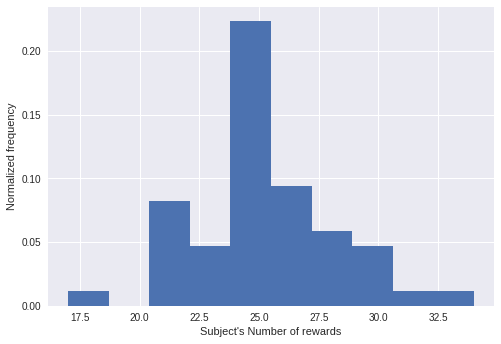

In [6]:
import matplotlib.pyplot as plt

plt.hist(number_of_rewards, normed=True, bins=10)
plt.ylabel('Normalized frequency');
plt.xlabel("Subject's Number of rewards");

###Effect of reward on next choice

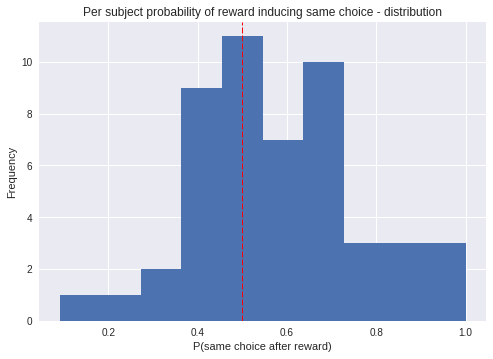

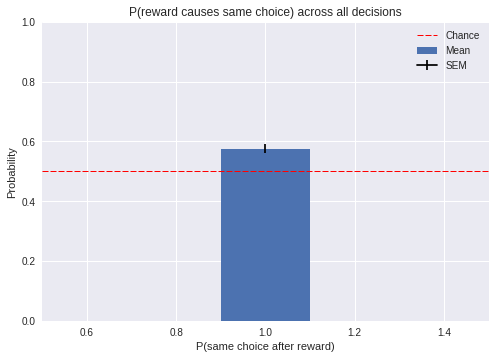

In [7]:
import numpy as np
from scipy import stats

is_same_chioce_after_reward_each_user_average = [
  np.mean(user_is_same_choice) 
  for user_is_same_choice in is_same_chioce_after_reward_all_users]

# Probability per subject (distribution)
plt.ylabel('Frequency');
plt.xlabel('P(same choice after reward)');
plt.axvline(x=0.5,linewidth=1, color='r', dashes=[6, 2])
plt.title('Per subject probability of reward inducing same choice - distribution')
plt.hist(is_same_chioce_after_reward_each_user_average, bins=10)


# Probability across all subjects (mean)
plt.figure()
all_users_choices = [is_same_choice 
             for user in is_same_chioce_after_reward_all_users 
             for is_same_choice in user]
plt.bar(1, np.mean(all_users_choices), width=0.2)
plt.errorbar(1, np.mean(all_users_choices), stats.sem(all_users_choices), color="black")
plt.axhline(y=0.5,linewidth=1, color='r', dashes=[6, 2])
plt.xlim(.5,1.5)
plt.ylim(0,1)
plt.legend(['Chance','Mean','SEM'])
plt.title('P(reward causes same choice) across all decisions')
plt.ylabel('Probability');
plt.xlabel('P(same choice after reward)');



###Effect of NO reward on next choice

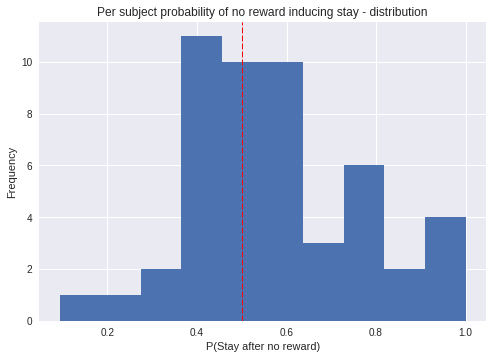

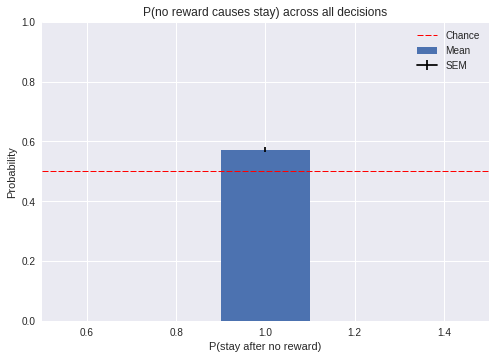

In [8]:
PLOT_IS_SWITCH_AFTER_NO_REWARD = False # if false, plot is *stay* after no reward

is_switch_after_no_reward_each_user_average = [
  np.mean(user_is_switch) 
  for user_is_switch in is_switch_after_no_reward_all_users]

is_stay_after_no_reward_each_user_average = [
  1-np.mean(user_is_switch) 
  for user_is_switch in is_switch_after_no_reward_all_users]


# Probability per subject (distribution)
if PLOT_IS_SWITCH_AFTER_NO_REWARD:
  plt.hist(is_switch_after_no_reward_each_user_average, bins=10)
  plt.title('Per subject probability of no reward inducing switch - distribution')
  plt.xlabel('P(Switch after no reward)');

else:
  plt.hist(is_stay_after_no_reward_each_user_average, bins=10)
  plt.title('Per subject probability of no reward inducing stay - distribution')
  plt.xlabel('P(Stay after no reward)');

plt.ylabel('Frequency');
plt.axvline(x=0.5,linewidth=1, color='r', dashes=[6, 2])


# Probability across all subjects (mean)
plt.figure()
all_users_is_switch = [is_switch 
             for user in is_switch_after_no_reward_all_users 
             for is_switch in user]

all_users_is_stay_after_no_reward = [not is_switch
             for user in is_switch_after_no_reward_all_users 
             for is_switch in user]
if PLOT_IS_SWITCH_AFTER_NO_REWARD:
  plt.bar(1, np.mean(all_users_is_switch), width=0.2)
  plt.errorbar(1, np.mean(all_users_is_switch), 
               stats.sem(all_users_is_switch), color="black")
  plt.title('P(no reward causes switch) across all decisions')
  plt.xlabel('P(switch after no reward)');

else:
  plt.bar(1, np.mean(all_users_is_stay_after_no_reward), width=0.2)
  plt.errorbar(1, np.mean(all_users_is_stay_after_no_reward), 
               stats.sem(all_users_is_stay_after_no_reward), color="black")
  plt.title('P(no reward causes stay) across all decisions')
  plt.xlabel('P(stay after no reward)');


plt.axhline(y=0.5,linewidth=1, color='r', dashes=[6, 2])
plt.xlim(.5,1.5)
plt.ylim(0,1)
plt.legend(['Chance','Mean','SEM'])
plt.ylabel('Probability');



Outcome causes same sequential choice (REWARD-NO_REWARD): 0.37 %


(0, 3)

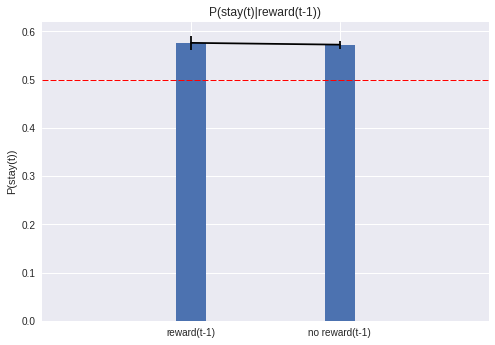

In [13]:
mean_after_reward = np.mean(all_users_choices)
sem_after_reward = stats.sem(all_users_choices)
mean_after_no_reward = np.mean(all_users_is_stay_after_no_reward)
sem_after_no_reward = stats.sem(all_users_is_stay_after_no_reward)


plt.bar([1, 2], [mean_after_reward, mean_after_no_reward], width=0.2)
plt.errorbar([1, 2], [mean_after_reward, mean_after_no_reward],
             [sem_after_reward, sem_after_no_reward], color="black")
plt.axhline(y=0.5,linewidth=1, color='r', dashes=[6, 2])

plt.title('P[stay(t)|reward(t-1)]')
plt.ylabel('P[stay(t)]');
plt.xticks([1, 2], ['reward(t-1)', 'no reward(t-1)'])
  
percentage_behavioral_change = 100*(np.mean(all_users_choices) - (1-np.mean(all_users_is_switch)))
print('Outcome causes same sequential choice (REWARD-NO_REWARD):', round(percentage_behavioral_change,2), '%')
plt.xlim(0,3)